In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Construct the path to the SQLite database located one directory above the current path
current_path = os.getcwd()
db_path = os.path.join(current_path, '..', 'db.sqlite3')

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

test_id_start = 257
test_id_end = 273
# Write and execute a query to fetch data
query = """
SELECT 
    d.id, 
    d.distance, 
    d.error_distance, 
    d.test_id,
    t.test_group_id,
    t.real_test_distance,
    t.comments
FROM 
    sit_ble_devices_distancemeasurement d
JOIN 
    sit_ble_devices_devicetests t ON d.test_id = t.id
WHERE 
    t.test_group_id BETWEEN 35 and 39
"""
test_data = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

In [14]:
print(test_data)

           id   distance  error_distance  test_id  test_group_id  \
0       72312   0.938071       -0.070929      195             35   
1       72313   0.938071       -0.070929      195             35   
2       72314   0.938071       -0.070929      195             35   
3       72315   0.961523       -0.047477      195             35   
4       72316   0.933381       -0.075619      195             35   
...       ...        ...             ...      ...            ...   
35061  107380  15.023213       -0.025787      273             39   
35062  107381  15.041974       -0.007026      273             39   
35063  107382  15.041974       -0.007026      273             39   
35064  107383  15.037284       -0.011716      273             39   
35065  107384  15.027904       -0.021096      273             39   

       real_test_distance        comments  
0                   1.009  13. two device  
1                   1.009  13. two device  
2                   1.009  13. two device  
3      

In [3]:
# Assuming test_data is your DataFrame
grouped = test_data.groupby('test_id').agg({
    'distance': ['min', 'max', 'mean'],
    'error_distance': ['min', 'max', 'mean'],
    'comments': 'first'
    })
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped['absolute_error_mean'] = grouped['error_distance_mean'].abs()
# Reset index to turn the group labels into columns
grouped.reset_index(inplace=True)

# Print the new DataFrame
print(grouped.sort_values(by='absolute_error_mean'))

    test_id  distance_min  distance_max  distance_mean  error_distance_min  \
27      225      2.931473      3.048732       3.002982           -0.070527   
26      224      2.940854      3.039351       3.003104           -0.061146   
24      222      2.936163      3.044042       3.003357           -0.065837   
25      223      2.936163      3.048732       3.004893           -0.065837   
32      232      4.967088      5.037443       5.000080           -0.035912   
..      ...           ...           ...            ...                 ...   
33      233      5.267271      5.342317       5.301867            0.264271   
20      218      3.245727      3.348915       3.308925            0.243727   
23      221      3.231656      3.353605       3.309028            0.229656   
64      265     15.403131     15.459416      15.431002            0.354131   
61      262     15.398441     15.459416      15.432418            0.349441   

    error_distance_max  error_distance_mean     comments_first 

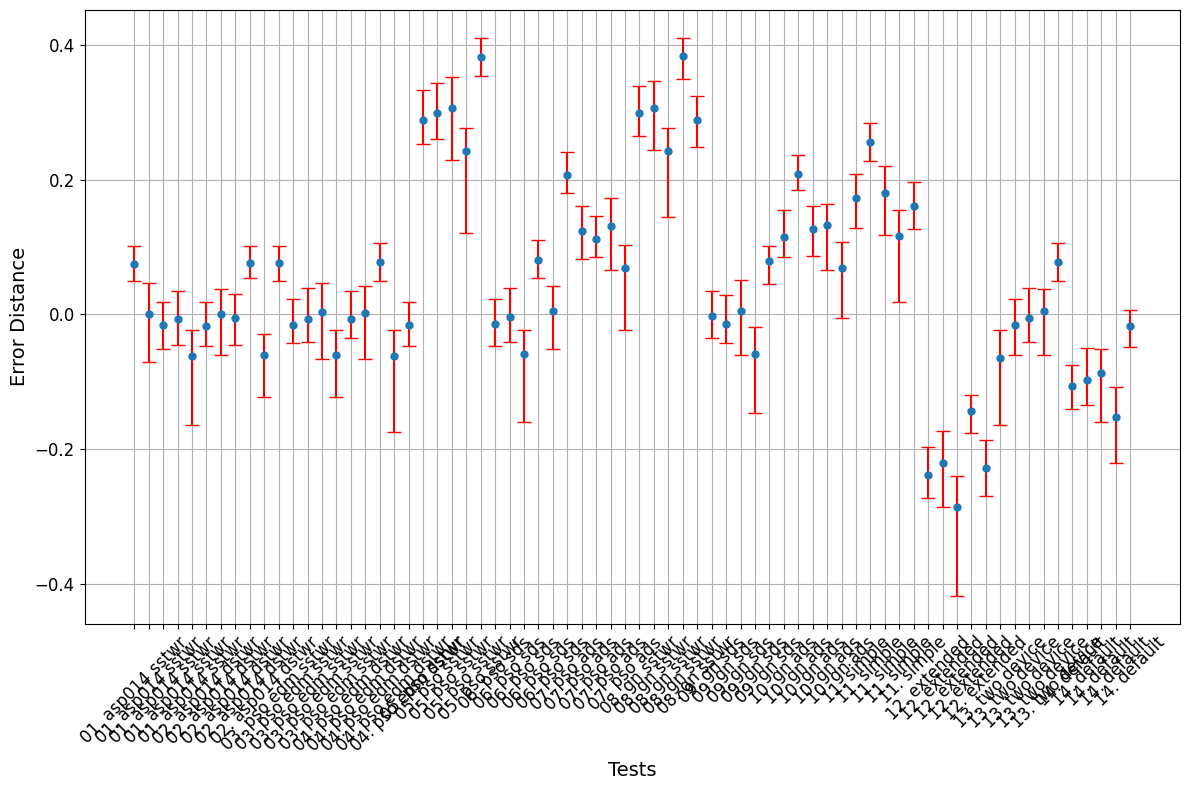

In [4]:
file_name = f'error_distance_{int(test_data['real_test_distance'].iloc[0])}m.pdf'
# Prepare the data
data_sorted = grouped.sort_values(by='comments_first')

x = range(1, len(grouped) + 1)  # X-axis points
y = data_sorted['error_distance_mean'].values  # Mean error_distance as central points
yerr = [data_sorted['error_distance_mean'].values - data_sorted['error_distance_min'].values,  # Lower error
        data_sorted['error_distance_max'].values - data_sorted['error_distance_mean'].values]  # Upper error

# Plot the data
plt.figure(figsize=(12, 8))
plt.errorbar(x, y, yerr=yerr, fmt='o', ecolor='r', capsize=5, linestyle='None', markersize=5)

# Customize the plot
#plt.title(f'Error Distance for {int(test_data['real_test_distance'].iloc[0])} m')
plt.ylabel('Error Distance', fontsize=14)
plt.xlabel('Tests', fontsize=14)
plt.xticks(x, data_sorted['comments_first'].astype(str), rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(file_name)
plt.show()


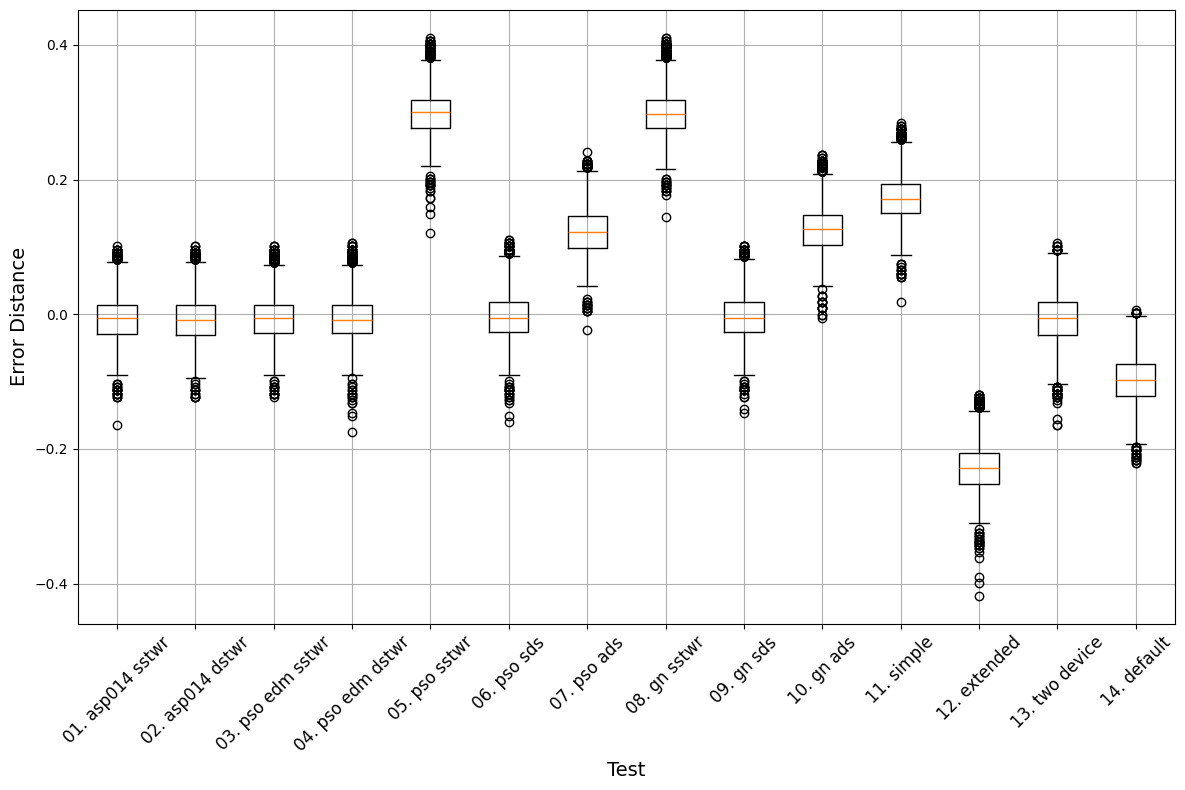

In [5]:
file_name = f'boxplot_error_{int(test_data['real_test_distance'].iloc[0])}m.pdf'
# Group the data by 'test_id' and collect all 'error_distance' values
test_data_sorted = test_data.sort_values(by='comments')
data_to_plot = [group['error_distance'].tolist() for _, group in test_data_sorted.groupby('comments')]

# Create the boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(data_to_plot)

# Customize the plot
plt.ylabel('Error Distance', fontsize=14)
plt.xlabel('Test', fontsize=14)
plt.xticks(range(1, len(data_to_plot) + 1), test_data_sorted['comments'].unique(), rotation=45, fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(file_name)
# Display the plot
plt.show()

In [6]:
# Function to calculate RMSE
def calculate_rmse(group):
    print(type(group))
    return np.sqrt(np.mean(group ** 2))

# Group by 'test_id' and calculate RMSE for each group
grouped = test_data.groupby('test_id').agg({
    'error_distance': calculate_rmse,
    'distance': 'mean',
    'real_test_distance': 'first',
    'test_group_id': 'first',
    'comments': 'first'
    }).reset_index()

# Rename the 'error_distance' column to 'rmse'
grouped.rename(columns={'error_distance': 'rmse'}, inplace=True)
pd.set_option('display.max_rows', None)
# Print the new DataFrame with RMSE, test_group_id, and comments
print(grouped.sort_values(by=['comments', 'distance']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

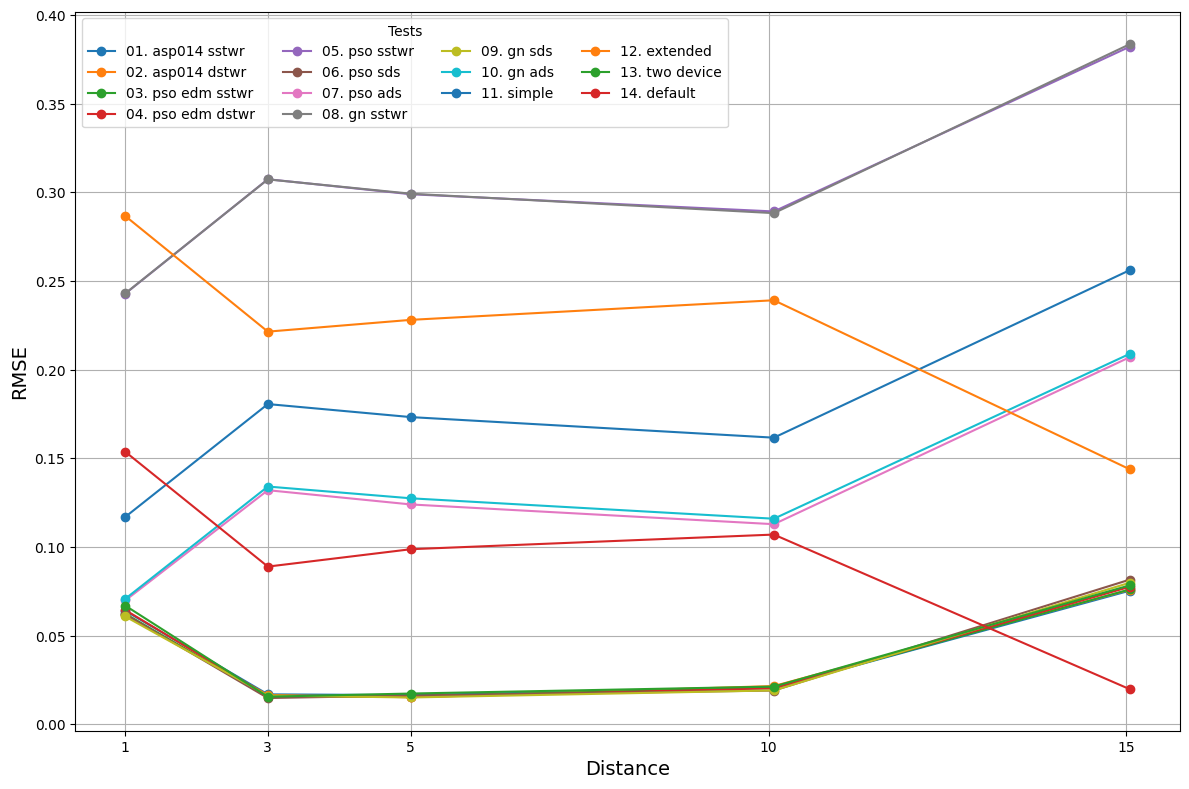

In [15]:
import matplotlib.pyplot as plt
file_name = f'distance_to_rmse'
# Plotting
plt.figure(figsize=(12, 8))
grouped_sorted = grouped.sort_values(by=['comments', 'distance'])
pivot_tabel = grouped_sorted.pivot_table(index='comments', columns='real_test_distance', values='rmse', aggfunc='first')
latex_str = pivot_tabel.to_latex(index=True, caption="RMSE", label="tab:rmse", float_format="%.3f")

with open(file_name + '.tex', 'w') as f:
    f.write(latex_str)

# Iterate over each unique comment group
for comment in grouped_sorted['comments'].unique():
    subset = grouped_sorted[grouped_sorted['comments'] == comment]
    plt.plot(subset['real_test_distance'], subset['rmse'], label=comment, marker='o')

# Customize the plot
plt.xlabel('Distance', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xticks([1, 3, 5, 10, 15])
plt.legend(title='Tests', loc='upper left', ncols=4)
plt.grid(True)
plt.tight_layout()
plt.savefig(file_name + '.pdf')
# Show the plot
plt.show()

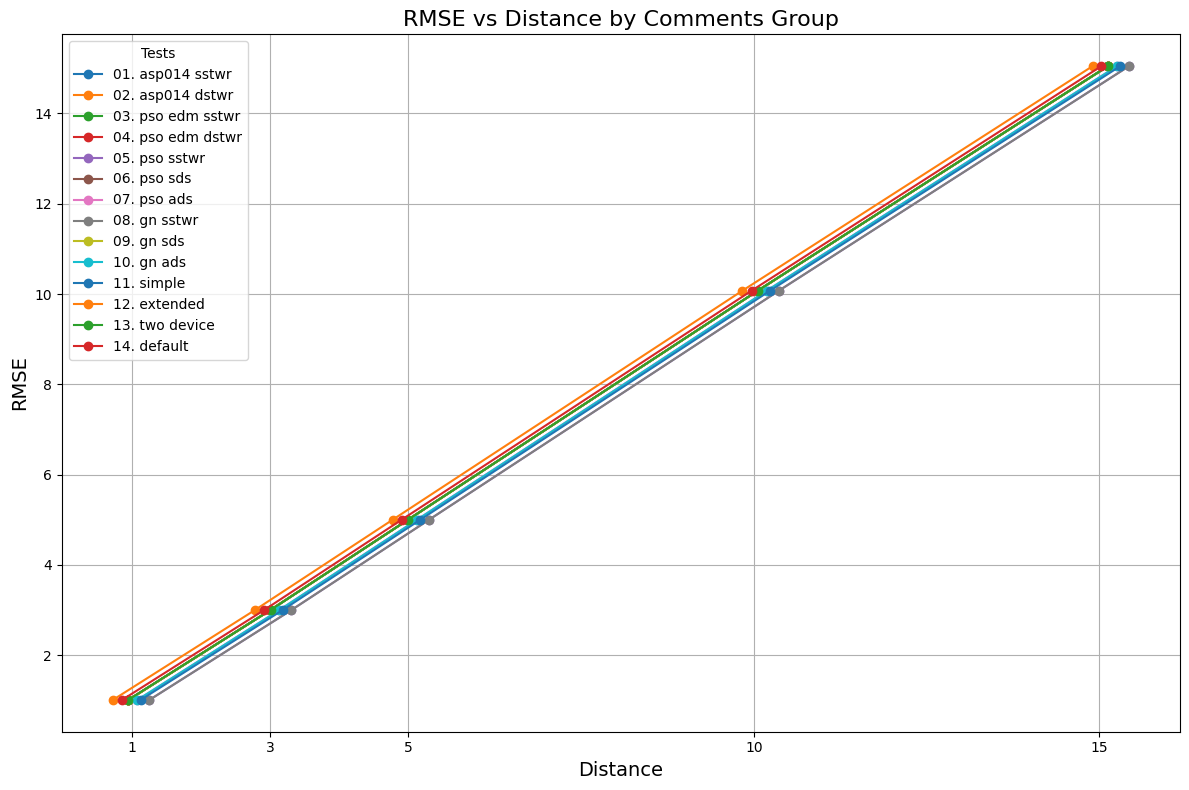

In [16]:
file_name = f'distance_to_real_distance'
# Plotting
plt.figure(figsize=(12, 8))
grouped_sorted = grouped.sort_values(by=['comments', 'distance'])

pivot_tabel = grouped_sorted.pivot_table(index='comments', columns='real_test_distance', values='distance', aggfunc='first')
latex_str = pivot_tabel.to_latex(index=True, caption="Distance in m", label="tab:distance", float_format="%.3f")

with open(file_name + '.tex', 'w') as f:
    f.write(latex_str)


# Iterate over each unique comment group
for comment in grouped_sorted['comments'].unique():
    subset = grouped_sorted[grouped_sorted['comments'] == comment]
    plt.plot(subset['distance'], subset['real_test_distance'], label=comment, marker='o')

# Customize the plot
plt.xlabel('Distance', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.xticks([1, 3, 5, 10, 15])
plt.title('RMSE vs Distance by Comments Group', fontsize=16)
plt.legend(title='Tests')
plt.grid(True)
plt.tight_layout()
plt.savefig(file_name + '.pdf')
# Show the plot
plt.show()

In [10]:
import shutil

# Quellpfad der Datei
source_file = os.path.join(os.getcwd(), file_name + '.pdf')

# Zielordner
destination_folder = r"D:\Microsoft\OneDrive\Fachhochschule\Master\00_Facharbeiten\40_Masterstudienarbeit\01_Ausarbeitung\content\6-kapitel6\bilder"

# Ziel Dateipfad
destination_file = os.path.join(destination_folder, file_name + '.pdf')

# Kopieren der Datei
shutil.copy(source_file, destination_file)

'D:\\Microsoft\\OneDrive\\Fachhochschule\\Master\\00_Facharbeiten\\40_Masterstudienarbeit\\01_Ausarbeitung\\content\\6-kapitel6\\bilder\\distance_to_rmse.pdf'